# Основы PyTorch

## Задача №1

- Объявите вещественные тензор `x` размера (4, 4, 5) и тензор `y` размера (2, 5, 8), иницилизируйте их равномерным распределением.
- Создайте их копии на GPU
- Затем измените форму тензора `y`, чтобы она совпадала с формой тензора `x`, получите тензор `z`  
- Переместите `z` на CPU
- Выведите сумму и разность `x` и `y`

In [ ]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
x = torch.FloatTensor(4,4,5)
y = torch.FloatTensor(2,5,8)

In [ ]:
x_cuda = x.cuda()
y_cuda = y.cuda()

In [ ]:
y = y.view(4,4,5)

In [ ]:
print("Сумма = ", x.add(y))
print("Разность = ", x.sub(y))

Сумма =  tensor([[[-4.2307e-25,  8.9330e-41, -4.2307e-25,  8.9330e-41,  3.2230e-43],
         [ 0.0000e+00,         nan,         nan,  2.6485e-43,  0.0000e+00],
         [ 2.3159e-38,  3.3108e-41, -5.1188e-11,  4.4664e-41, -6.4192e-16],
         [ 8.9329e-41, -1.2776e-30,  4.4665e-41,  1.0469e-38,  9.1837e-39]],

        [[        nan,  1.0319e-38,  1.0469e-38,  9.2755e-39,  1.0653e-38],
         [ 1.0194e-38,  4.2246e-39,  1.0194e-38,  1.0929e-38,  1.0469e-38],
         [ 3.6736e-39,  3.7654e-39,  9.1854e-40,  9.9186e-39,  4.2246e-39],
         [ 9.6432e-39,  1.0745e-38,  9.2755e-39,  9.3674e-39,  9.4594e-39]],

        [[ 9.6429e-39,  9.2757e-39,  3.6736e-39,  4.4082e-39,  2.9388e-39],
         [ 3.7653e-39,  9.1841e-40,  9.9184e-39,  4.2246e-39,  9.0919e-39],
         [ 1.0653e-38,  9.2755e-39,  3.6736e-39,  8.3572e-39,  4.0408e-39],
         [ 4.4081e-39,  4.0409e-39,  8.0816e-39,  5.3266e-39,  2.9388e-39]],

        [[ 8.5408e-39,  2.9388e-39,  5.6021e-39,  1.0469e-38,  9.1837e-39

In [ ]:
z = y.view(4,4,5)

In [ ]:
z = z.cuda()

# Задача №2. Функции активации

Мы поняли, что пороговая функция активации сулит нам много проблем. Что если попробовать что-то другое?

Начнем с сигмоиды.

У сигмоиды все в порядке с производной. Можем взять производную функции потерь по весам и спускаться в пространстве параметров в направлении наискорейшего убывания функции потерь. Формула для обновления весов в градиентном спуске:

$$w^{j+1} = w^{j} - \alpha \frac{\partial Loss}{\partial w} (w^{j})$$

Распишем дальше:

* Для веса $w_j$:

$$ \frac{\partial Loss}{\partial w_j} =
\frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)(\sigma(w \cdot x_i))_{w_j}' = \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij}$$

* Градиент функции потерь по вектору весов - это вектор, $j$-ая компонента которого равна $\frac{\partial Loss}{\partial w_j}$:

$$\begin{align}
    \frac{\partial Loss}{\partial w} &= \begin{bmatrix}
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i1} \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i2} \\
           \vdots \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{im}
         \end{bmatrix}
\end{align}=\frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

Таким образом, сигмоида отлично подходит. Осталось реализовать в коде.

* Реализуйте сигмоиду и её производную:

In [ ]:
def sigmoid(x): # сигмойда
    return 1 / (1 + torch.exp(-x))

In [ ]:
def sigmoid_derivative(x): # производная сигмоиды
    sig = sigmoid(x)
    return sig * (1 - sig)

In [ ]:
def mse_loss(y_pred, y): # функция потерь
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)

    return 0.5 * np.mean((y_pred - y) ** 2)

In [ ]:
class Perceptron_Sigmoid:
    def __init__(self, w=None, b=0):

        self.w = w
        self.b = b

    def activate(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, X): # прямой проход
        y_pred = self.activate(np.dot(X, self.w) + self.b)
        return y_pred.reshape(-1,1)

    def backward(self, X, y, y_pred, learning_rate=0.005): # обратный проход
        n = X.shape[0]
        y = np.array(y).reshape(-1,1)

        dw = (2/n) * np.dot(X.T, (y_pred - y) * y_pred * (1 - y_pred))
        db = (2/n) * np.sum((y_pred - y) * y_pred * (1 - y_pred))

        self.w -= learning_rate*dw
        self.b -= learning_rate*db

    def fit(self, X, y, num_epochs=5000):

        self.w = np.zeros((X.shape[1], 1))  # вектор весов
        self.b = 0  # смещение
        loss_values = []  # значения функции потерь на различных итерациях обновления весов

        for i in range(num_epochs):
            y_pred = self.forward(X)
            loss_values.append(mse_loss(y_pred,y))
            self.backward(X,y,y_pred)

        return np.array(loss_values)

In [ ]:
rng = np.random.default_rng()
data_0 = np.concatenate([rng.normal((-1, -1), 1, (500, 2)), np.zeros((500, 1))], axis=1) # сэмплируем нули
data_1 = np.concatenate([rng.normal((1, 1), 1, (500, 2)), np.ones((500, 1))], axis=1) # сэмплируем единицы

In [ ]:
def random_mix(X_1, X_2): # перемешиваем
    c = np.concatenate((X_1, X_2))
    np.random.shuffle(c)
    return c

In [ ]:
data = random_mix(data_0, data_1) # получаем наш набор данных

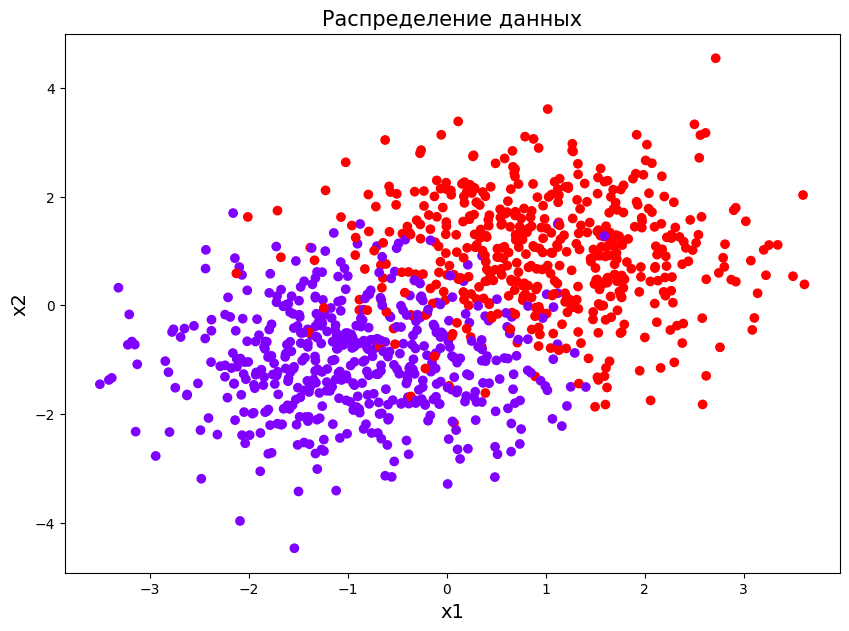

In [ ]:
plt.figure(figsize=(10, 7)) # отрисуем его
plt.scatter(data[:, 0], data[:, 1], c=data[:, [2]], cmap='rainbow')
plt.title('Распределение данных', fontsize=15)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.show()

In [ ]:
X = data[:, [0, 1]] # обучающая выборка
y = data[:, [2]] # целевая переменная

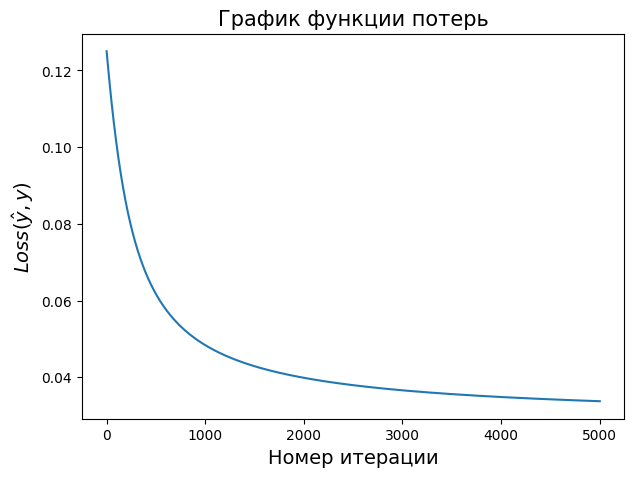

In [ ]:
perceptron = Perceptron_Sigmoid()
losses = perceptron.fit(X,y)

# массив с номерами итераций
num_epochs = 5000
iterations = np.arange(1, num_epochs + 1)

plt.figure(figsize=(7, 5))
plt.plot(iterations, losses)
plt.title('График функции потерь', fontsize=15)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

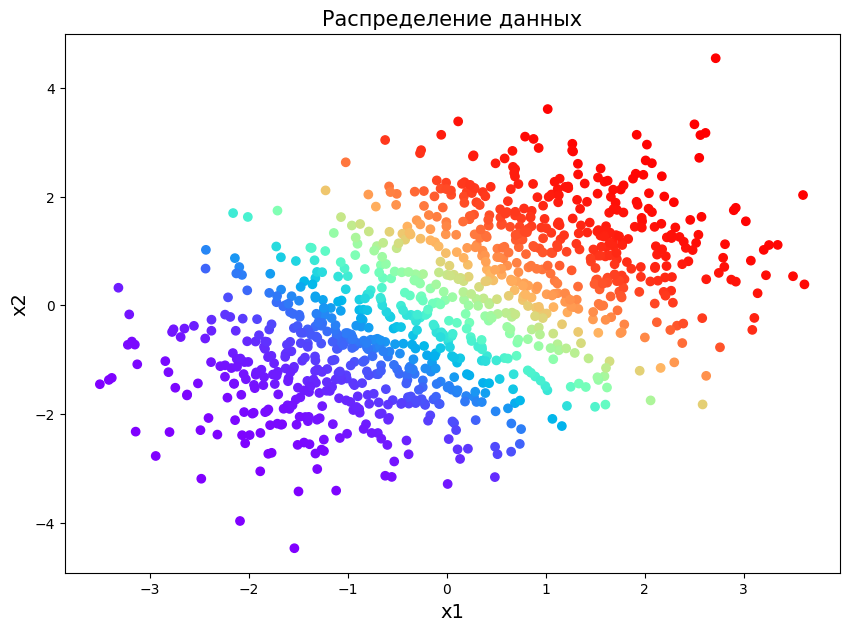

In [ ]:
pred = perceptron.forward(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=pred, cmap='rainbow')
plt.title('Распределение данных', fontsize=15)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.show()

In [ ]:
print(accuracy_score(np.array(perceptron.forward(X) > 0.5).ravel(), y)) # рассчитаем значение accuracy

0.923


In [ ]:
print(accuracy_score(perceptron.forward(X).ravel()>0.5, y)) # рассчитаем значение accuracy

0.923


ReLU выглядит очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В переводе Rectified Linear Unit = "Усечённая линейная функция". Мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Тогда формула для обновления весов при градиентном спуске будет такая:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

Почему в первом случае будет 0? Потому что в $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [ ]:
def relu(x):
    return np.maximum(0, x)

In [ ]:
def relu_derivative(x):
    return 1 if x > 0 else 0

In [ ]:
class Perceptron_ReLU:
    def __init__(self, w=None, b=0):

        self.w = w
        self.b = b

    def activate(self, x):
        return relu(x)

    def forward(self, X):

        n = X.shape[0]
        y_pred = self.activate(np.dot(X, self.w) + self.b)
        return y_pred.reshape(-1,1)

    def backward(self, X, y, y_pred, learning_rate=0.005):

        n = len(y)
        y = np.array(y).reshape(-1, 1)

        dw = (2/n) * np.dot(X.T, (y_pred - y) * y_pred * (1 - y_pred))
        db = (2/n) * np.sum((y_pred - y) * y_pred * (1 - y_pred))

        self.w -= learning_rate*dw
        self.b -= learning_rate*db

    def fit(self, X, y, num_epochs=5000):

        self.w = np.zeros((X.shape[1], 1))  # вектор весов
        self.b = 0  # смещение (число)
        loss_values = []  # значения функции потерь на различных итерациях обновления весов

        for i in range(num_epochs):
            y_pred = self.forward(X)
            loss_values.append(mse_loss(y_pred,y))
            self.backward(X,y,y_pred)

        return np.array(loss_values)

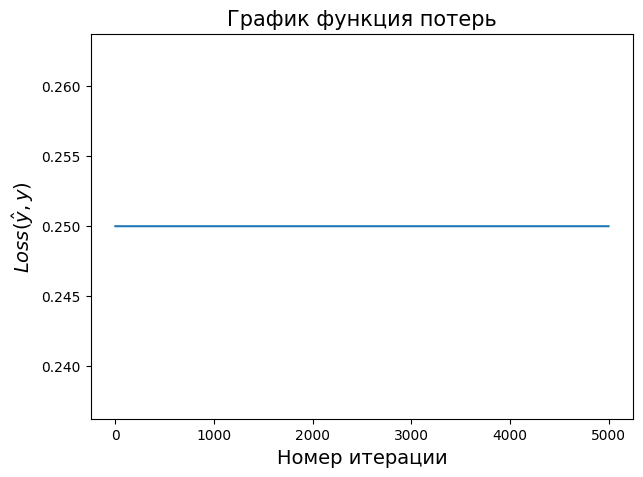

In [ ]:
perceptron = Perceptron_ReLU()
losses = perceptron.fit(X,y)

plt.figure(figsize=(7, 5))
plt.plot(losses)
plt.title('График функция потерь', fontsize=15)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

In [ ]:
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# изменим класс, чтобы избежать "мертвых" нейронов
class Perceptron_ReLU_v2:

    def __init__(self, input_size):
        self.w = np.random.randn(input_size, 1)  # инициализация весов случайными числами
        self.b = 0

    def activate(self, x):
        return relu(x)

    def forward(self, X):
        n = X.shape[0]
        y_pred = self.activate(np.dot(X, self.w) + self.b)
        return y_pred.reshape(-1, 1)

    def backward(self, X, y, y_pred, learning_rate=0.005):
        n = len(y)
        y = np.array(y).reshape(-1, 1)

        dw = (2/n) * np.dot(X.T, (y_pred - y) * relu_derivative(y_pred))
        db = (2/n) * np.sum((y_pred - y) * relu_derivative(y_pred))

        self.w -= learning_rate * dw
        self.b -= learning_rate * db

    def fit(self, X, y, num_epochs=5000):
        self.w = np.random.randn(X.shape[1], 1)  # инициализация весов случайными числами
        self.b = 0
        loss_values = []

        for i in range(num_epochs):
            y_pred = self.forward(X)
            loss = mse_loss(y_pred, y)
            loss_values.append(loss)
            self.backward(X, y, y_pred)

        return np.array(loss_values)

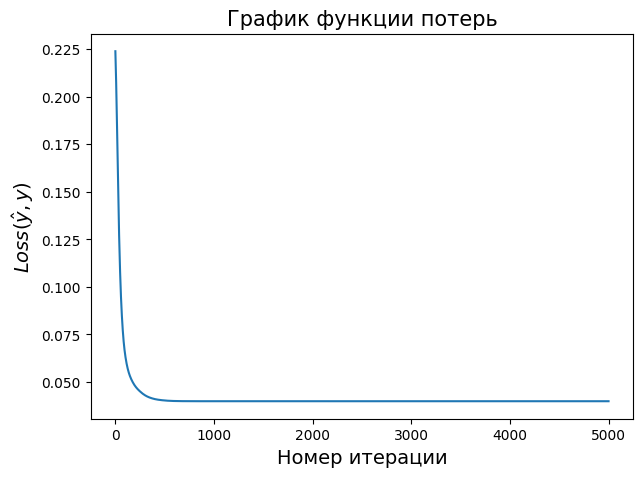

In [ ]:
perceptron = Perceptron_ReLU_v2(input_size=X.shape[1])
losses = perceptron.fit(X, y, num_epochs=5000)

plt.figure(figsize=(7, 5))
plt.plot(losses.reshape(-1,))
plt.title('График функции потерь', fontsize=15)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

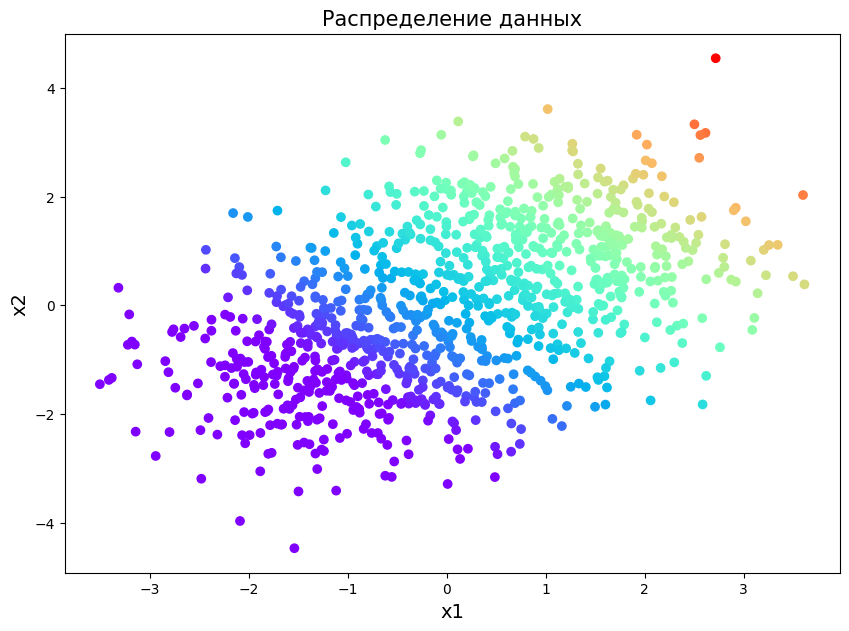

In [ ]:
pred = perceptron.forward(X)

plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=pred, cmap='rainbow')
plt.title('Распределение данных', fontsize=15)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.show()

In [ ]:
print(accuracy_score(np.array(perceptron.forward(X) > 0.5).ravel(), y)) # рассчитаем значение accuracy

0.922
